Epoch[1/5], Total Loss: 16268.9598, Reconst Loss: 14653.9854, KL Div: 1614.9744867, Val Loss: 12618.8120


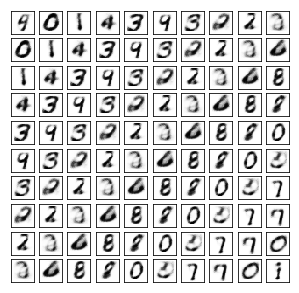

Epoch[2/5], Total Loss: 11885.8943, Reconst Loss: 9532.5947, KL Div: 2353.2995303, Val Loss: 11409.4109


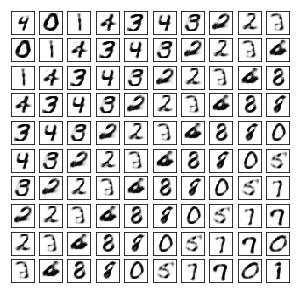

Epoch[3/5], Total Loss: 11183.4718, Reconst Loss: 8658.5591, KL Div: 2524.9127100, Val Loss: 11024.3086


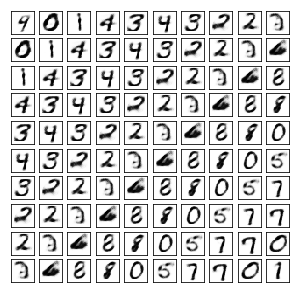

Epoch[4/5], Total Loss: 10883.7020, Reconst Loss: 8298.2079, KL Div: 2585.4941118, Val Loss: 10825.4638


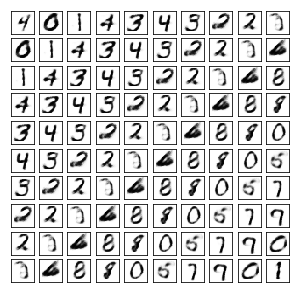

Epoch[5/5], Total Loss: 10702.6666, Reconst Loss: 8088.7318, KL Div: 2613.9348628, Val Loss: 10677.6685


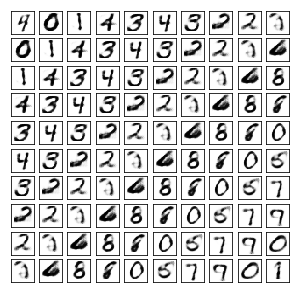


Sampled images from latent space:


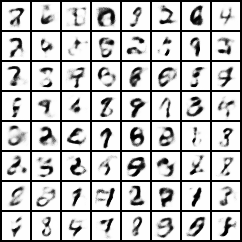

Interpolating between two randomly sampled


Visualizing latent space groupings


Epoch[1/3], Total Loss: 19123.5802, Reconst Loss: 18541.3207, KL Div: 582.2595649, Val Loss: 16990.1152
Epoch[2/3], Total Loss: 16753.7362, Reconst Loss: 16226.5750, KL Div: 527.1612346, Val Loss: 16476.1294
Epoch[3/3], Total Loss: 16428.2271, Reconst Loss: 15902.4819, KL Div: 525.7452275, Val Loss: 16305.1144

Exploring latent representations


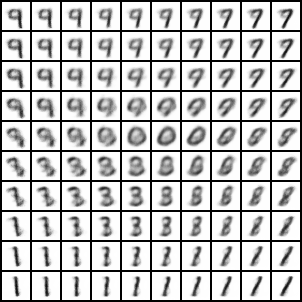

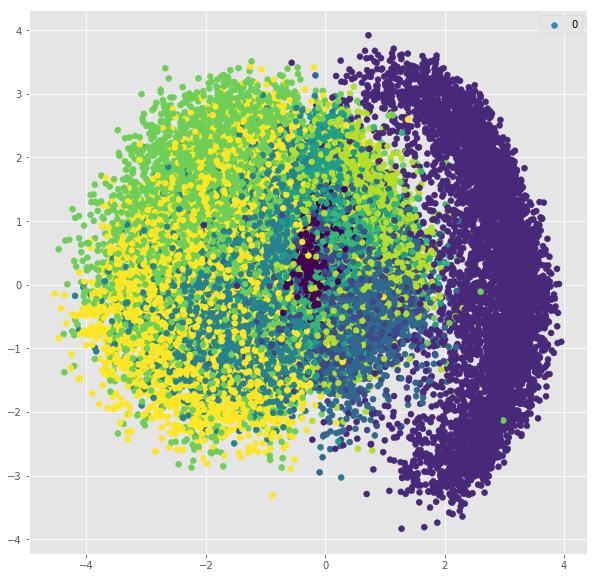

In [1]:
""" (VAE)
Variational Autoencoder

https://arxiv.org/pdf/1312.6114.pdf

From the abstract:

"We introduce a stochastic variational inference and learning algorithm that scales to large datasets
and, under some mild differentiability conditions, even works in the intractable case. Our contributions 
is two-fold. First, we show that a reparameterization of the variational lower bound yields a lower bound 
estimator that can be straightforwardly optimized using standard stochastic gradient methods. Second, we 
show that for i.i.d. datasets with continuous latent variables per datapoint, posterior inference can be
made especially efficient by fitting an approximate inference model (also called a recognition model) to 
the intractable posterior using the proposed lower bound estimator."

Basically VAEs encode an input into a given dimension z, reparametrize that z using it's mean and std, and 
then reconstruct the image from reparametrized z. This lets us tractably model latent representations that we 
may not be explicitly aware of that are in the data. For a simple example of what this may look like, read
up on "Karl Pearson's Crabs." The basic idea was that a scientist collected data on a population of crabs,
noticed that the distribution was non-normal, and Pearson postulated it was because there were likely
more than one population of crabs studied. This would've been a latent variable, since the data colllector
did not know.

"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binzarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Encoder(nn.Module):
    """ MLP encoder for VAE. Input is an image, 
    outputs is the mean and std of the latent representation z pre-reparametrization 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim) 
        self.log_var = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, x):
        activated = F.relu(self.linear(x)) #leaky relu?
        mu, log_var = self.mu(activated), self.log_var(activated)
        return mu, log_var


class Decoder(nn.Module):
    """ MLP decoder for VAE. Input is a reparametrized latent representation, 
    output is reconstructed image """
    def __init__(self, z_dim, hidden_dim, image_size):
        super(Decoder, self).__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.recon = nn.Linear(hidden_dim, image_size)
        
    def forward(self, z):
        activated = F.relu(self.linear(z))
        reconstructed = torch.sigmoid(self.recon(activated))
        return reconstructed


class VAE(nn.Module):
    """ VAE super class to reconstruct an image. Contains reparametrization method 
    """
    def __init__(self, image_size=784, hidden_dim=400, z_dim=20):
        super(VAE, self).__init__()
        
        self.encoder = Encoder(image_size = image_size, hidden_dim = hidden_dim, z_dim = z_dim)
        self.decoder = Decoder(z_dim = z_dim, hidden_dim = hidden_dim, image_size = image_size)
                     
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)
        return out_img, mu, log_var
    
    def reparameterize(self, mu, log_var):
        """" Reparametrization trick: z = mean + std*epsilon, where epsilon ~ N(0, 1)."""
        epsilon = to_cuda(torch.randn(mu.size(0), mu.size(1)))
        z = mu + epsilon * torch.exp(log_var/2)    # 2 for convert var to std
        return z


class VAETrainer:
    def __init__(self, model, train_iter, val_iter, test_iter, viz=False):
        """ Object to hold data iterators, train the model """
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.debugging_image, _ = next(iter(val_iter))
        self.viz = viz
    
    def train(self, num_epochs, lr=1e-3, weight_decay=1e-5):
        """ Train a Variational Autoencoder
            Logs progress using total loss, reconstruction loss, kl_divergence, and validation loss

        Inputs:
            num_epochs: int, number of epochs to train for
            lr: float, learning rate for Adam optimizer (default 1e-3)
            weight_decay: float, weight decay for Adam optimizer (default 1e-5)
        """   
        
        # Initialize best validation loss for early stopping
        best_val_loss = 1e10
        
        # Adam optimizer, sigmoid cross entropy for reconstructing binary MNIST
        optimizer = torch.optim.Adam(params=[p for p in self.model.parameters() if p.requires_grad], lr=lr, weight_decay=weight_decay)
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            
            self.model.train()
            epoch_loss, epoch_recon, epoch_kl = [], [], []
            
            for batch in self.train_iter:
                
                # Zero out gradients
                optimizer.zero_grad()
                
                # Compute reconstruction loss, Kullback-Leibler divergence for a batch
                recon_loss, kl_diverge = self.compute_batch(batch)
                batch_loss = recon_loss + kl_diverge # ELBO
                
                # Update parameters
                batch_loss.backward()
                optimizer.step()
                
                # Log metrics
                epoch_loss.append(batch_loss.item())
                epoch_recon.append(recon_loss.item())
                epoch_kl.append(kl_diverge.item())
            
            # Test the model on the validation set
            val_loss = self.evaluate(self.val_iter)
            
            # Early stopping
            if val_loss < best_val_loss:
                self.best_model = deepcopy(self.model)
                best_val_loss = val_loss
                
            # Progress logging
            print ("Epoch[%d/%d], Total Loss: %.4f, Reconst Loss: %.4f, KL Div: %.7f, Val Loss: %.4f" 
                   %(epoch, num_epochs, np.mean(epoch_loss), np.mean(epoch_recon), np.mean(epoch_kl), val_loss))
            
            # Debugging and visualization purposes
            if self.viz:
                self.reconstruct_images(self.debugging_image, epoch)
                plt.show()
                
    def compute_batch(self, batch):
        """ Compute loss for a batch of examples """
        images, _ = batch
        images = to_cuda(images.view(images.shape[0], -1))
        
        output, mu, log_var = self.model(images)
        
        recon_loss = -torch.sum(torch.log(torch.abs(output - images) + 1e-8))

        kl_diverge = self.kl_divergence(mu, log_var)
        
        return recon_loss, kl_diverge
    
    def evaluate(self, iterator):
        """ Evaluate on a given dataset """
        loss = []
        for batch in iterator:
            recon_loss, kl_diverge = self.compute_batch(batch)
            batch_loss = recon_loss + kl_diverge
            loss.append(batch_loss.item())
            
        loss = np.mean(loss)
        return loss
    
    def reconstruct_images(self, images, epoch, save=True):
        """Reconstruct a fixed input at each epoch for progress visualization """
        # Reshape images, VAE output
        images = to_cuda(images.view(images.shape[0], -1))
        reconst_images, _, _ = self.model(images)
        reconst_images = reconst_images.view(reconst_images.shape[0], 28, 28)
        
        # Plot
        plt.close()
        size_figure_grid = int(reconst_images.shape[0]**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(reconst_images[i+j].data.numpy(), cmap='gray')
        
        # Save
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.data, 
                                         outname + 'real.png',
                                         nrow=size_figure_grid)
            torchvision.utils.save_image(reconst_images.unsqueeze(1).data, 
                                         outname + 'reconst_%d.png' %(epoch),
                                         nrow=size_figure_grid)
            
    def kl_divergence(self, mu, log_var):
        """ Compute Kullback-Leibler divergence """
        return torch.sum(0.5 * (mu**2 + torch.exp(log_var) - log_var - 1))
    
    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model. If model not specified, instantiate it """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


# OPTIONAL: Visualization / latent-space sampling methods
class Viz:
    """ Visualize and sample latent space """
    def __init__(self, model=None):
        self.model = model
        
    def sample_images(self, num_images=64):
        """ Viz method 1: generate images by sampling z ~ p(z), x ~ p(x|z,θ) """
        # Sample from latent space randomly, visualize output
        sample = to_cuda(torch.randn(num_images, self.model.decoder.linear.in_features))
        sample = self.model.decoder(sample)
        to_img = ToPILImage()
        img = to_img(make_grid(sample.data.view(num_images, 1, 28, 28)))
        display(img)
        
    def sample_interpolated_images(self):
        """ Viz method 2: sample two random latent vectors from p(z), 
        then sample from their interpolated values
        """
        # Sample latent vectors
        z1 = torch.normal(torch.zeros(self.model.decoder.linear.in_features), 1)
        z2 = torch.normal(torch.zeros(self.model.decoder.linear.in_features), 1)
        to_img = ToPILImage()
        
        # Interpolate within latent vectors
        for alpha in np.linspace(0, 1, self.model.decoder.linear.in_features):
            z = to_cuda(alpha*z1 + (1-alpha)*z2)
            sample = self.model.decoder(z)
            display(to_img(make_grid(sample.data.view(28, 28).unsqueeze(0))))
            
    def means_scatterplot(self, num_epochs=3):
        """ Viz method 3: train a VAE with 2 latent variables, compare variational means """
                
        # Initialize and train a VAE with size two dimension latent space
        model = VAE(image_size=784, hidden_dim=400, z_dim=2)
        trainer = VAETrainer(model, train_iter, val_iter, test_iter)
        trainer.train(num_epochs)
        model = trainer.best_model

        # Across batches in train iter, collect variationa means
        data = []
        for batch in train_iter:
            images, labels = batch
            images = to_cuda(images.view(images.shape[0], -1))
            mu, log_var = model.encoder(images)

            for label, (m1, m2) in zip(labels, mu):
                data.append((label.item(), m1.item(), m2.item()))

        # Plot
        plt.style.use('ggplot')

        labels, m1s, m2s = zip(*data)
        plt.figure(figsize=(10,10))
        plt.scatter(m1s, m2s, c=labels)
        plt.legend([str(i) for i in set(labels)])
        return model

    def explore_latent_space(self):
        """ Viz method 4: explore the latent space representations """
        
        # Evenly sample acorss latent space, visualize the outputs
        mu = torch.stack([torch.FloatTensor([m1, m2]) 
                          for m1 in np.linspace(-2, 2, 10) 
                          for m2 in np.linspace(-2, 2, 10)])
        samples = self.model.decoder(to_cuda(mu))
        to_img = ToPILImage()
        display(to_img(make_grid(samples.data.view(-1, 1, 28, 28), nrow=10)))
        
    def make_all(self):
        """ Execute all viz methods outlined in this class """
        
        print('Sampled images from latent space:')
        self.sample_images()
        
        print('Interpolating between two randomly sampled')
        self.sample_interpolated_images()
        
        print('Visualizing latent space groupings')
        self.model = self.means_scatterplot()
        
        print('Exploring latent representations')
        self.explore_latent_space()


model = VAE(image_size=784, 
            hidden_dim=400, 
            z_dim=20)

trainer = VAETrainer(model=model,
                     train_iter=train_iter, 
                     val_iter=val_iter, 
                     test_iter=test_iter,
                     viz=True)

trainer.train(num_epochs=5,
              lr=1e-3,
              weight_decay=1e-5)

# Explore latent space
viz = Viz(trainer.best_model)
viz.make_all()